## we will derive and implement the diffusion process. We will use MNIST dataset to build a diffusion model to generate digits.

We will start with variational autoencoders 

$$
\log p_\theta(x)  \geq \sum_{q_\phi(z|x)} \log p_\theta(x|z) - KL(q_\phi(z|x) || p_\theta(z))
$$

The detailed derivation is given in the VAE notebook. 

In diffusion model, we will consider decoder as forward process and encoder as reverse process. we will consider latent variable z as x at different timesteps t=1,2,3...T and observed variable as x_0.

$$
\log p_\theta(x_{0})  \geq \sum_{q_\phi(x_{1:T}|x_{0})} \log p_\theta(x_{0:T}|x_{0}) - KL(q_\phi(x_{1:T}|x_{0}) || p_\theta(x_{1:T}|x_{0}))
$$

The detailed derivation is given [here](https://github.com/AakashKumarNain/diffusion_models/blob/main/notebooks/deep_dive_into_ddpms.ipynb)

I m writing the final equations used in this notebook 

## linear beta schedule 

we have $\beta_{min}$ and $\beta_{max}$ as min and max values of beta. 

$$
\beta_{t} = \beta_{min} + (t/T) * (\beta_{max} - \beta_{min})
$$

Forward process is defined as 

$$
q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_{t}}x_{t-1}, \beta_{t}I)
$$


$$
x_t = \sqrt{1-\beta_{t}}x_{t-1} + \sqrt{\beta_{t}} \epsilon_{t}
$$

where $\epsilon_{t}$ is standard normal noise. 

Using reparametrization trick we can write treat $\alpha_{t}$ as 1-$\beta_{t}$, so after serveral steps of derivations we get $x_{t}$ in terms of $x_{0}$ as 

$$
x_t = \sqrt{\bar{\alpha}_{t}} x_0 + \sqrt{1-\bar{\alpha}_{t}} \epsilon_{t}
$$

where $\bar{\alpha}_{t} = \prod_{i=1}^{t} \alpha_{i}$ and $\alpha_{i} = 1-\beta_{i}$


while training in reverse process we will use $x_{t-1}$ in terms of $x_{t}$ and $\epsilon_{t}$

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} (x_{t} - \frac{1- \alpha_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \epsilon_{t}) + \sigma_{t} z
$$

Note that 

$$
\sigma^2_{t} = \beta_{t} \text{ or } \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}} \beta_{t}
$$

we will use the second one for $\sigma^2_{t}$ here. 

Also z is standard normal noise and $\epsilon_{t}$ is noise in forward process which is predicted by a deep learning model.

The loss function is defined as 

$$
L = \mathbb{E}_{x_0, \epsilon} [|| \epsilon - \epsilon_\theta(x_t, t) ||^2]
$$

where $\epsilon$ is noise added in forward process and $\epsilon_\theta$ is noise predicted by the model.



In [1]:
# Looad required libraries 

import torch 
import numpy as np
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 

# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=128, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=128, shuffle=False)

len(train_loader), len(val_loader)

(469, 79)

In [3]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

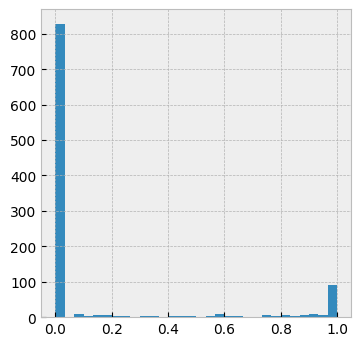

In [4]:
plt.figure(figsize=(4, 4))
plt.hist(imgs[0].view(-1).numpy(), bins=30) #-1 is more because background is black. 
plt.show()


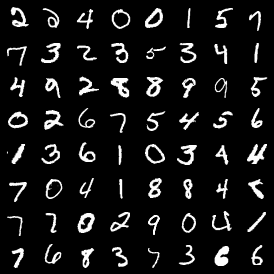

In [5]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs[:64], nrow=8, normalize=False))

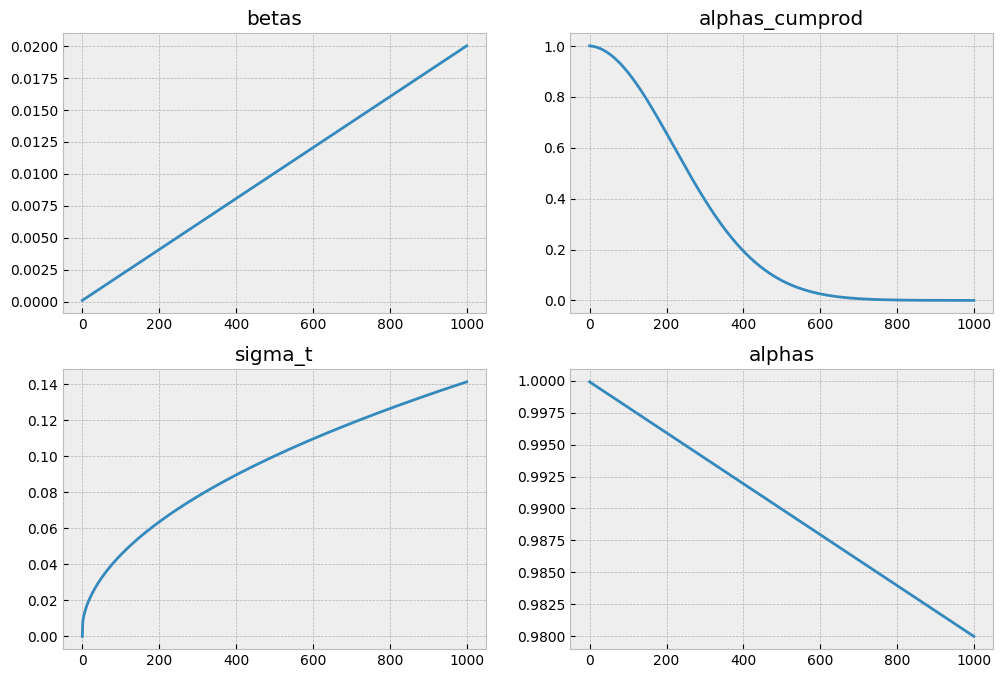

In [6]:
## Lets add some noise to the images using linear beta schedule  
T = 1000
beta_min = 0.0001
beta_max = 0.02
betas = torch.linspace(beta_min, beta_max, T)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]], dim=0)
sigma_t = torch.sqrt((1 - alphas_cumprod_prev) / (1 - alphas_cumprod)* betas)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax.flat[0].plot(betas)
ax.flat[1].plot(alphas_cumprod)
ax.flat[2].plot(sigma_t)
ax.flat[3].plot(alphas)
ax.flat[0].set_title('betas')
ax.flat[1].set_title('alphas_cumprod')
ax.flat[2].set_title('sigma_t')
ax.flat[3].set_title('alphas')
plt.show()



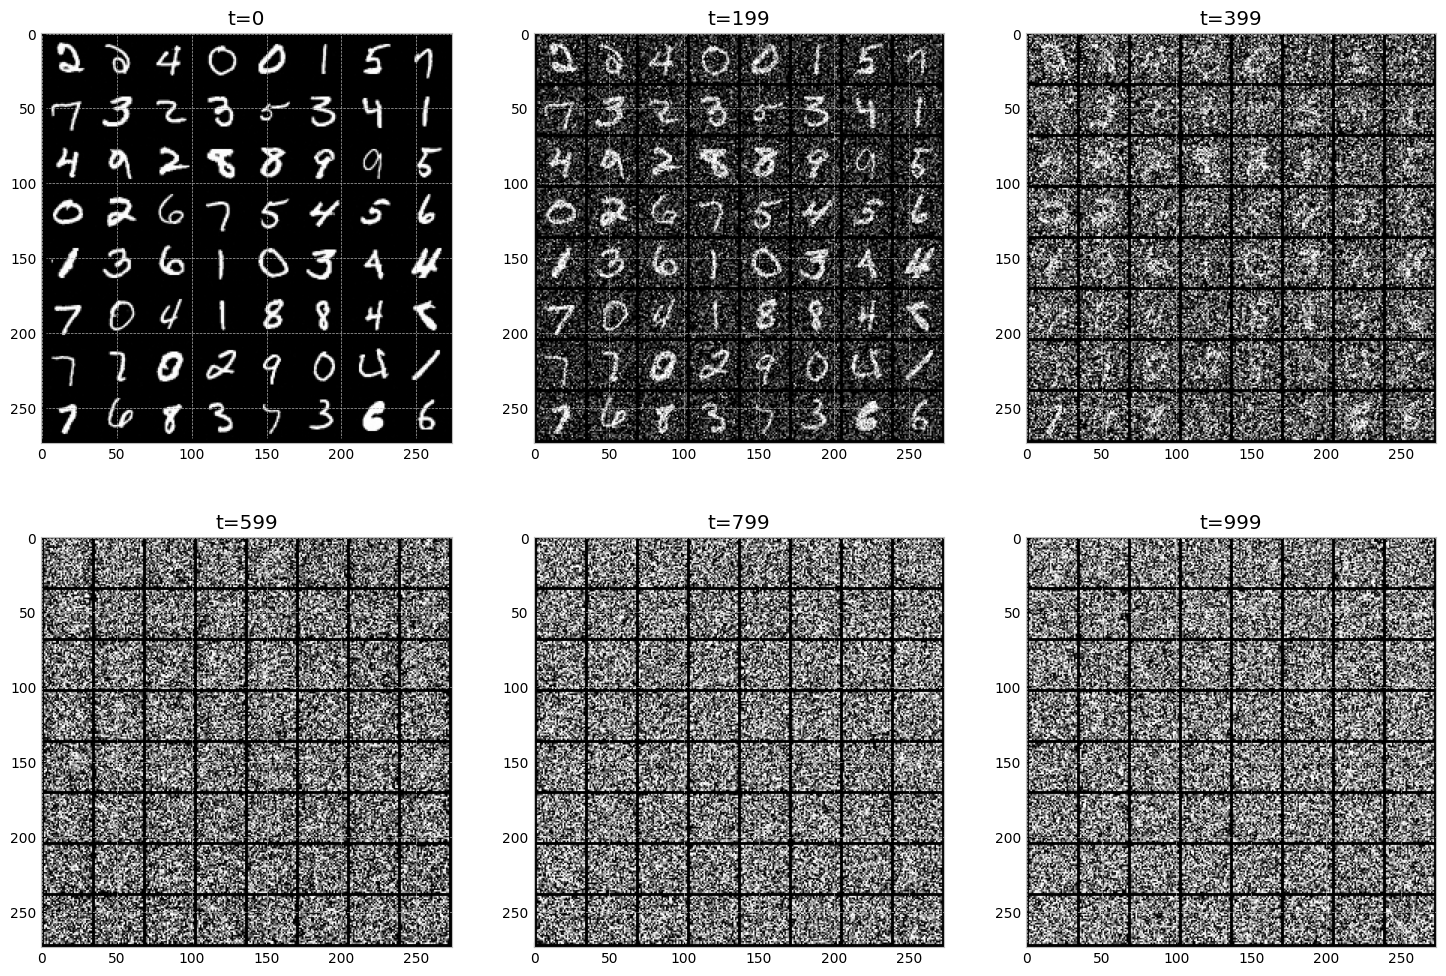

In [7]:
# Lets visualize the forward process (markov process) T = 0, 20, 40, 60, 80, 100
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for n, i in enumerate([0, 199, 399, 599, 799, 999]):
    imgsn = 2*imgs-1 
    xt = torch.sqrt(alphas_cumprod[i]) * imgsn + torch.sqrt(1 - alphas_cumprod[i]) * torch.randn_like(imgsn)
    xt = xt.clamp(-1, 1)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(xt[:64], nrow=8, normalize=True))
    ax.flat[n].imshow(np.asarray(img))
    ax.flat[n].set_title(f't={i}')
plt.show()

In [18]:
# forward step given x0 and t 
def forward_step(x0, t, noise=None):
    alpha_t = alphas_cumprod[t]
    if noise is None:
        noise = torch.randn_like(x0)
    xt = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    return xt

In [21]:
# Forward process is defined using a UNet architecture. 
# from the paper Our neural network architecture follows the backbone of PixelCNN++ [52], which is a U-Net [48]
# based on a Wide ResNet [72]. We replaced weight normalization [49] with group normalization [66]
# to make the implementation simpler. Our 32 × 32 models use four feature map resolutions (32 × 32
# to 4 × 4), and our 256 × 256 models use six. All models have two convolutional residual blocks
# per resolution level and self-attention blocks at the 16 × 16 resolution between the convolutional
# blocks [6]. Diffusion time t is specified by adding the Transformer sinusoidal position embedding [60]
# into each residual block. Our CIFAR10 model has 35.7 million parameters, and our LSUN and
# CelebA-HQ models have 114 million parameters. We also trained a larger variant of the LSUN
# Bedroom model with approximately 256 million parameters by increasing filter count.
#TODO: implement our own UNet architecture instead of using diffusers

from diffusers import UNet2DModel

device = "cuda"
model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2, #use 3
    block_out_channels=(128, 256, 512, 512),  
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),  # Add attention
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),  # Add attention
    time_embedding_type='positional',
)

model = model.to(device)

In [22]:
count = 0
for name, param in model.named_parameters():
    count += param.numel()
count # this is a ~16 million parameters model


101117185

In [23]:
# During inference/validation
@torch.no_grad()
def sample_ddpm(model, n_samples, device):
    # Start from pure noise
    x = torch.randn((n_samples, 1, 32, 32)).to(device)
    img_list = []
    
    for t in tqdm(reversed(range(T)), desc='sampling loop time step'):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        
        # Predict noise
        pred_noise = model(x, t_batch)["sample"]
        
        # Update sample with improved scheduler
        alpha = alphas[t]
        alpha_hat = alphas_cumprod[t]
        sigma = sigma_t[t]
        
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
            
        posterior_mean = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * pred_noise) 
        posterior_std = sigma * noise
        x = posterior_mean + posterior_std

        if t in [0, 199, 399, 599, 799, 999]:
            img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x.clamp(-1, 1).cpu(), nrow=8, normalize=True))
            img_list.append(img)
    
    return x.clamp(-1, 1), img_list

sampling loop time step: 1000it [00:31, 31.61it/s]


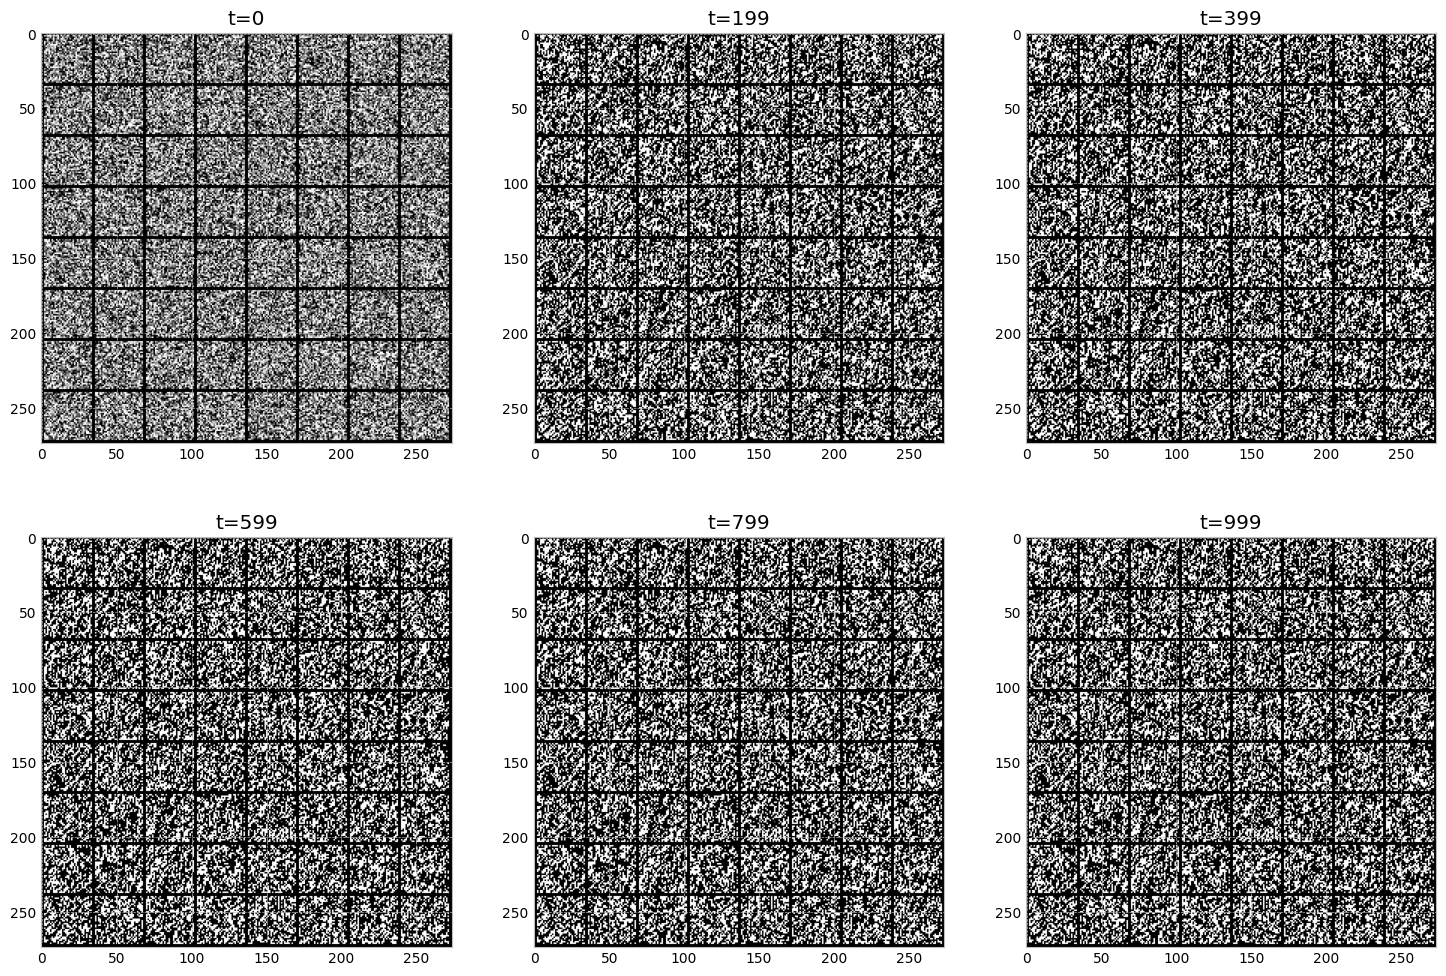

In [24]:
final_img, img_list = sample_ddpm(model, 64, device)

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for n, (img, t) in enumerate(zip(img_list, [0, 199, 399, 599, 799, 999])):
    ax.flat[n].imshow(np.asarray(img))
    ax.flat[n].set_title(f't={t}')
plt.show()


In [17]:
epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4) #suggested by cursor. 
total_steps = len(train_loader) * epochs
noise = torch.randn((64, 1, 32, 32), device=device)

iter = 0 
train_loss = []

for epoch in range(epochs):
    model.train()
    epoch_loss = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            optimizer.zero_grad()
            x0, _ = batch
            t = torch.randint(0, T, (x0.shape[0],), device=x0.device)
            x0 = 2*x0 -1  # scale to -1 to 1
            noise = torch.randn_like(x0)
            xt = forward_step(x0, t.view(-1, 1, 1, 1), noise)
            model_output = model(xt.to(device), t.to(device))["sample"]
            loss = torch.nn.functional.mse_loss(model_output, noise.to(device))
            tepoch.set_postfix(loss=loss.item())
            epoch_loss.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()
    train_loss.extend(epoch_loss)
    print(f"Epoch {epoch} completed: train loss {np.mean(epoch_loss)}")
    #TODO: save the model
    #TODO: calculate some metric between generated images and original images

    # During validation we will take a fixed set of random noise and generate images using the model
    # with torch.no_grad():
    #     noise_t = noise.clone().to(device)
    #     for time in tqdm(range(T-1)):
    #         pred_noise = model(noise_t, torch.tensor([T-1-time], device=device))["sample"]
    #         # x_{t-1} = 1/sqrt(alpha_t) (x_t - ((1-alpha_t)/sqrt(1-alpha_t) * pred_noise)) + sigma_t * z
    #         noise_t = 1/torch.sqrt(alphas_cumprod[T-1-time]) * (noise_t - ((1-alphas_cumprod[T-1-time])/torch.sqrt(1-alphas_cumprod[T-1-time])) * pred_noise) + torch.sqrt(betas[T-1-time]) * (torch.randn_like(noise_t) if time > 0 else torch.zeros_like(noise_t))
    #     img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(noise_t.clamp(-1, 1).cpu(), nrow=8, normalize=True))
    #     img.save(f"generated/generated_images_{epoch}.png")
    model.eval()
    out, _ = sample_ddpm(model, 128, device)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=8, normalize=True))
    img.save(f"generated/generated_images_{epoch}.png")
        

100%|██████████| 469/469 [00:37<00:00, 12.47batch/s, loss=1]    


Epoch 0 completed: train loss 1.0010857427043955


sampling loop time step: 1000it [00:20, 48.49it/s]
100%|██████████| 469/469 [00:36<00:00, 12.69batch/s, loss=0.999]


Epoch 1 completed: train loss 1.0002057279096737


sampling loop time step: 1000it [00:20, 48.53it/s]
100%|██████████| 469/469 [00:36<00:00, 12.68batch/s, loss=0.999]


Epoch 2 completed: train loss 1.000385341486697


sampling loop time step: 1000it [00:20, 48.50it/s]
100%|██████████| 469/469 [00:37<00:00, 12.67batch/s, loss=0.995]


Epoch 3 completed: train loss 0.9999164014991159


sampling loop time step: 1000it [00:20, 48.52it/s]
100%|██████████| 469/469 [00:36<00:00, 12.69batch/s, loss=1]    


Epoch 4 completed: train loss 1.000217971517079


sampling loop time step: 1000it [00:20, 48.55it/s]
 94%|█████████▎| 439/469 [00:34<00:02, 12.68batch/s, loss=0.991]


KeyboardInterrupt: 

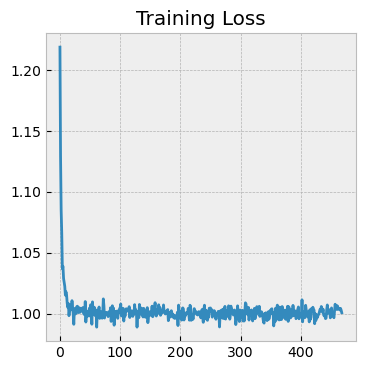

In [18]:
plt.figure(figsize=(4, 4))
plt.plot(train_loss)
plt.title("Training Loss")
plt.show()

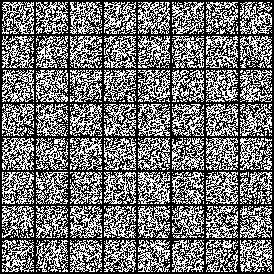

In [20]:
img

In [14]:
final_img, img_list = sample_ddpm(model, 64, "mps")

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for n, (img, t) in enumerate(zip(img_list, [0, 199, 399, 599, 799, 999])):
    ax.flat[n].imshow(np.asarray(img))
    ax.flat[n].set_title(f't={t}')
plt.show()

NameError: name 'sample_ddpm' is not defined

In [28]:
## TODO:DDIM sampling and see if the model is able to generate similar better images. 


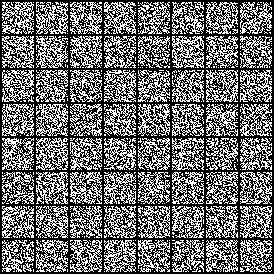

In [32]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(final_img.clamp(-1, 1).cpu(), nrow=8, normalize=True))